# Lab Assignment 5: Wide and Deep Network Architectures
## Prediction of Hospital Readmission Using Wide & Deep Neural Networks

In this lab, We implement and test **wide and deep network architectures** on the *Diabetes 130-US Hospitals* dataset. The objective is to predict the **hospital readmission status** for patients with diabetes, using a combination of demographic, admission, diagnosis, and utilization features.

The target variable `readmitted` has three possible values:

- `"NO"` – patient was not readmitted
- `">30"` – patient was readmitted more than 30 days after discharge
- `"<30"` – patient was readmitted within 30 days

This naturally results in a **multi-class classification problem with three classes**, meeting the assignment requirement.

#### Business Case:
A commercial version of the readmission-risk model might be commercialized as a decision-support platform for hospitals and integrated delivery networks that are looking to avoid penalties and costs associated with preventable readmissions among patients with diabetes. Integrated with an EHR, the model would produce a real-time risk score at discharge (or earlier in the inpatient stay) for each encounter with a diabetic patient, and identify the highest risk patients who are most likely to be readmitted within 30 days. The health system could then use scarce resources (care coordinators, telehealth follow-up, medication reconciliation, home-health visits, etc.) on those high-risk patients where it will make the biggest difference to patient outcomes and most likely avoid wasteful utilization. The product could be commercialized as a subscription SaaS offering that includes model hosting and ongoing retraining on local data, dashboard visualizations for clinicians and administrators, and integration services, with the value proposition demonstrated through improved readmission rates, improved quality metrics on value-based care contracts, and realized financial savings.

### Dataset Description

The dataset is the “Diabetes 130-US hospitals for years 1999–2008” (Strack et al., UCWe / Kaggle). Each row in the dataset represents a hospital **encounter** of a patient with diabetes in one of 130 US hospitals or integrated delivery networks. Data attributes include: 

- Patient demographic attributes (such as race, gender, age)
- Admission and discharge information 
- ICD-9 diagnosis codes (`diag_1`, `diag_2`, `diag_3`) 
- Lab results and indicators (`max_glu_serum`, `A1Cresult`) 
- Information on diabetes related medication and changes to diabetes medications
- The **readmission status** (`readmitted`), which is the multi-class target in this lab

The dataset is **tabular** with multiple **categorical features** and the **target is a 3-class** outcome, so it is suitable for training wide and deep networks with embeddings and cross-product features.

Group: Jonathan Scurtis & James Nielson | Date: November 16, 2025

In [2]:
# Setup and Data Loading
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.impute import KNNImputer

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print("TensorFlow version: ", tf.__version__)

path = "data\diabetic_data.csv"

df = pd.read_csv(path)

df.head()


TensorFlow version:  2.15.0


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


### Target Definition and Initial Filtering 

The target for this lab is the `readmitted` column, which indicates if and when a patient was readmitted. Before encoding the target, We apply some clinically/statistically motivated filters:

- Remove invalid gender values (retain only `"Male"` and `"Female"`).
- Remove encounters where the patient died or went to hospice (using `discharge_disposition_id` codes indicating death/hospice). These encounters are not useful for predicting readmission.
- Retain only the first encounter per patient. Later encounters are functionally information about a patient already present in the system (through their earlier encounter(s)) and violate the i.i.d. assumption of independent observations in the data, and can also leak data between training and validation folds (appear earlier in training, later in validation) resulting in an over-optimistic estimate of validation error. Keeping only the first encounter per patient better approximates a more realistic use-case of predicting readmission risk for a new patient encounter.

In [3]:
## Target + Basic Filtering
print("Original Shape: ", df.shape)

# Drop rows with invalid gender (if any)
df = df[df["gender"].isin(["Male", "Female"])]

# Remove discharge dispositions where patient died or was sent to hospice
# According to the UCWe description, the following IDs indicate death/hospice:
# 11: Expired, 19,20,21: Hospice
death_hospice_ids = [11, 19, 20, 21]
df = df[~df["discharge_disposition_id"].isin(death_hospice_ids)]

# Keep only the first encounter per patient
df = df.sort_values(["patient_nbr", "encounter_id"])
df = df.groupby("patient_nbr").head(1).reset_index(drop=True)

print("After basic filtering:", df.shape)

# Check target distribution
df["readmitted"].value_counts(normalize=True)


Original Shape:  (101766, 50)
After basic filtering: (70436, 50)


readmitted
NO     0.594838
>30    0.315776
<30    0.089386
Name: proportion, dtype: float64

### Feature Selection and Handling Missing Values 

We transform the data as follows to get it ready for modeling:

#### Dropping Low-Value or Identifier Columns 

The following columns are identifiers or just don't have much predictive value.

- `encounter_id` and `patient_nbr` are just identifiers. 
- `weight` is super sparse (extremely high proportion of missing).
- `payer_code` is a lot of missing data and not really relevant to the readmission task.

We drop these from the dataset. 

#### Replacing Missing Markers and Inspecting Missingness 

The data set uses the string `"? "` as a marker for missing values. We replace these with `NaN` and then check out the amount of missingness by column to help with imputation decisions.

In [4]:
# Feature Selection + Missing Value Clean-Up

df = df.replace("?", np.nan)

drop_columns = [
    "encounter_id",
    "patient_nbr",
    "weight",
    "payer_code"
]

df = df.drop(columns=drop_columns)

# Examine Missing Values
missing_counts = df.isna().sum().sort_values(ascending=False)
missing_counts.head(15)

max_glu_serum        67051
A1Cresult            57558
medical_specialty    33940
race                  1920
diag_3                1225
diag_2                 294
diag_1                  11
tolbutamide              0
pioglitazone             0
rosiglitazone            0
acarbose                 0
miglitol                 0
troglitazone             0
tolazamide               0
glipizide                0
dtype: int64

### Final Feature Schema and KNN Imputation

In this section, We define my predictor schema and replace missing values in a principled way.

#### Feature Groups

  **Categorical Features** (string or low-cardinality integer-like categories) :
      + `race`
      + `gender`
      + `age`
      + `admission_type_id`
      + `discharge_disposition_id`
      + `admission_source_id`
      + `medical_specialty`
      + `max_glu_serum`
      + `A1Cresult`
      + `change` (indicator whether diabetes medications were changed)
      + `diabetesMed` (indicator whether the patient is on diabetes medication)
      + `diag_1` (primary diagnosis ICD-9 code)
  **Numeric features** 
      + `time_in_hospital`
      + `num_lab_procedures`
      + `num_procedures`
      + `num_medications`
      + `number_outpatient`
      + `number_emergency`
      + `number_inpatient`
      + `number_diagnoses`

#### Imputation Strategy

  * For categorical variables, We :
      + convert them to string type and
      + impute missing values with the explicit category `"Unknown"`; by not aggregating missingness, we keep the information that some values were missing as a potentially informative signal in and of itself.

  * For numeric variables, We :
      + cast them to a proper numeric dtype and keep `NaN` values as-is
      + use **K-Nearest Neighbors imputation** (`KNNImputer` with `n_neighbors=5`) fit only on the numeric features. As the name implies, the KNN imputer imputes missing values based on the (potentially non-linear) similarity between patients in the numeric feature space, rather than using a single global statistic to replace missing values.

Finally, We remove any rows with missing values in the selected predictors or the target (rows 3864 and 3812).

In [5]:
## Defining Final Feature List and Basic Imputations

target_col = "readmitted"

categorical_cols = [
    "race",
    "gender",
    "age",
    "admission_type_id",
    "discharge_disposition_id",
    "admission_source_id",
    "medical_specialty",
    "max_glu_serum",
    "A1Cresult",
    "change",
    "diabetesMed",
    "diag_1"
]

numeric_cols = [
    "time_in_hospital",
    "num_lab_procedures",
    "num_procedures",
    "num_medications",
    "number_outpatient",
    "number_emergency",
    "number_inpatient",
    "number_diagnoses"
]

# Impute missing categorical with "Unknown" and cast to string
for col in categorical_cols:
    df[col] = df[col].astype(str).fillna("Unknown")

# Impute missing numeric data using KNN
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

knn_imputer = KNNImputer(n_neighbors=5)
numeric_imputed = knn_imputer.fit_transform(df[numeric_cols])

# Put the imputed values back into the data frame
df[numeric_cols] = numeric_imputed.astype("float32")

# Dropping any remaining rows that still have bad values in critical columns (however should be none)
df = df.dropna(subset=categorical_cols + numeric_cols + [target_col])

print("Final shape after KNN imputation and cleaning:", df.shape)
df.head()

Final shape after KNN imputation and cleaning: (70436, 46)


,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,Caucasian,Female,[50-60),2,1,1,8.0,Cardiology,77.0,6.0,...,No,Steady,No,No,No,No,No,Ch,Yes,<30
1,Caucasian,Female,[50-60),3,1,1,2.0,Surgery-Neuro,49.0,1.0,...,No,No,No,No,No,No,No,No,No,NO
2,Caucasian,Female,[80-90),1,3,7,4.0,InternalMedicine,68.0,2.0,...,No,No,No,No,No,No,No,No,Yes,NO
3,Caucasian,Female,[80-90),1,1,7,3.0,InternalMedicine,46.0,0.0,...,No,No,No,No,No,No,No,Ch,Yes,NO
4,AfricanAmerican,Female,[30-40),1,1,7,5.0,InternalMedicine,49.0,0.0,...,No,No,No,No,No,No,No,No,Yes,NO


### Target Encoding for Multi-Class Classification 

There are three different possible values for the `readmitted` column:

* `"NO"` 
* `">30"`` 
* `"<30"`` 

In order to be able to use this value for modeling with Keras, We convert these string labels to integer labels:

* `NO → 0` 
* `>30 → 1` 
* `<30 → 2` 

This results in a three-class classification problem. We also store the mapping dictionary for later use.

In [6]:
from sklearn.utils.class_weight import compute_class_weight

# Encoding Target as Integers

class_mapping = {"NO": 0, ">30": 1, "<30": 2}
y = df[target_col].map(class_mapping).values

num_classes = len(class_mapping)
print("Class Mapping: ", class_mapping)
print("Class Distribution: ", np.bincount(y))

# Compute class weights inversely proportional to class frequencies
classes = np.unique(y)
class_weights_arr = compute_class_weight(class_weight='balanced', classes=classes, y=y)

class_weight_dict = {cls: weight for cls, weight in zip(classes, class_weights_arr)}

print("Class weights:", class_weight_dict)

Class Mapping:  {'NO': 0, '>30': 1, '<30': 2}
Class Distribution:  [41898 22242  6296]
Class weights: {0: 0.5603767880726208, 1: 1.0556005155411683, 2: 3.729140194832698}


### Cross-Product Feature Design for the Wide Branch

The wide branch of a wide & deep network is designed to **memorize** sparse but highly predictive feature interactions. We define several cross-product features that combine clinically meaningful variables:

- `age × admission_type_id`  
  - Captures how age group interacts with admission type (e.g., elderly emergency vs. younger elective).

- `A1Cresult × diag_1`  
  - Captures interactions between long-term glycemic control (A1C status) and the primary diagnosis code.

- `race × discharge_disposition_id`  
  - Captures potential disparities or differences in readmission risk across racial groups and discharge destinations.

These cross features will be represented as combined string tokens (e.g., `"70-80|1"`), and encoded using `StringLookup` and `CategoryEncoding` as part of the wide branch.


In [7]:
## Building the Lookup and Encoding Layers
from tensorflow.keras.layers import StringLookup, CategoryEncoding, Embedding

# Preparing the numpy arrays for features
X_categorical = df[categorical_cols].copy()
X_numeric = df[numeric_cols].copy().values.astype("float32")

# Computing the mean and stan dev for numeric scaling
numeric_means = X_numeric.mean(axis=0)
numeric_stds = X_numeric.std(axis=0) + 1e-6 # the addition of the scalar term here helps by avoiding the division of zero

# Creating StringLookup for each of the categorical features
cat_lookup = {}

for col in categorical_cols:
    vocab = X_categorical[col].astype(str).values
    lookup = StringLookup(output_mode="int", oov_token="[UNK]")
    lookup.adapt(vocab)
    cat_lookup[col] = lookup

# For Wide Branch Net: employing CategoryEncoding layers for features and crosses
def make_one_hot_encoder(num_tokens):
    return CategoryEncoding(num_tokens=num_tokens, output_mode="binary")

wide_one_hot_layers = {}

for col in categorical_cols:
    vocab_size = cat_lookup[col].vocabulary_size()
    wide_one_hot_layers[col] = make_one_hot_encoder(vocab_size)

In [8]:
## Defining helper function to construct cross feature tensors

def make_cross_layer(name, lookup_a, lookup_b):
    """
    Creates a StringLookup + CategoryEncoding pipeline for cross feature creation
    """

    return {
        "name": name,
        "lookup_a": lookup_a,
        "lookup_b": lookup_b
    }

cross_defs = [
    ("age", "admission_type_id", "age_x_admission_type"),
    ("A1Cresult", "diag_1", "A1C_x_diag1"),
    ("race", "discharge_disposition_id", "race_x_discharge")
]


### Evaluation Metrics and “Bananas” Discussion 


The dataset is **class-imbalanced**: most encounters are `"NO"` readmission, with fewer `">30"` and even fewer `"<30"` readmissions. A model that always predicts `"NO"` could achieve relatively high **accuracy**, but would be clinically useless.

Therefore, We focus on: 

- **Macro-averaged AUROC** (one-vs-rest): 
- Measures the model's ability to rank positive vs. negative cases for each class, then averages across classes.
- Less sensitive to class imbalance than plain accuracy.

- **Macro-averaged F1-score**: 
- Balances precision and recall across classes, treating each class equally.

To motivate why accuracy alone is insufficient, imagine a banana-sorting scenario: if 90% of bananas are “good,” a robot that labels every banana as “good” reaches 90% accuracy, yet completely fails to detect “bruised” or “rotten” fruit. Similarly, in our readmission context, we are not satisfied with a “banana robot” that only recognizes the majority class. We need metrics like macro-AUROC (and optionally F1) that reflect performance across **all** clinically relevant outcomes, not just the dominant class.

### Helper Functions and Wide & Deep Model Variants 

To reduce some boilerplate code for training and evaluating, We define:

- `make_inputs(df_slice)` which takes a slice of the full DataFrame and produces a dictionary of NumPy arrays keyed by feature name (as required by the Keras Functional model call) which is suitable for passing to model training and evaluation.
- `train_one_model(model_builder, train_idx, val_idx, ...)` which: 
- Builds a new model, 
- Trains it with early stopping, 
- Returns the model, the training history, and the validation macro-AUROC.

Wide & deep model variants. We then define three wide & deep variants, as follows:

**Model A (WD_A)** 

- Deep hidden layers: `[64]` 
- Wide hidden units: `[64]` 
- Single cross feature only (`use_all_crosses=False`) 

**Model B (WD_B)** 

- Deep hidden layers: `[128, 64]` 
- Wide hidden units: `[64]` 
- All cross features (`use_all_crosses=True`) 
- We expect this to give the best results overall.

**Model C (WD_C)** 

- Deep hidden layers: `[256, 128, 64]` 
- Wide hidden units: `[32]` 
- Single cross feature only 
- We want to see if simply using deeper networks can make up for not using more cross features.

In [9]:
from tensorflow.keras import regularizers

def build_wide_and_deep_model(deep_hidden_layers=[128, 64], wide_hidden_units=[64], use_all_crosses=True, dropout_rate = 0.2):

    # Defining Inputs
    inputs = {}
    for col in categorical_cols:
        inputs[col] = keras.Input(shape=(1,), dtype=tf.string, name=col)
    for col in numeric_cols:
        inputs[col] = keras.Input(shape=(1,), dtype=tf.float32, name=col)

    # Deep Branch
    deep_embeddings = []
    for col in categorical_cols:
        x = inputs[col]
        lookup = cat_lookup[col]
        idx = lookup(x)  # integer indices

        vocab_size = lookup.vocabulary_size()
        # embedding dimension heuristic: floor(sqrt(vocab_size))
        embed_dim = int(np.floor(np.sqrt(vocab_size)))
        embed_dim = max(embed_dim, 2)

        emb = Embedding(
            input_dim=vocab_size,
            output_dim=embed_dim,
            name=f"emb_{col}"
        )(idx)
        emb = layers.Reshape((embed_dim,))(emb)
        deep_embeddings.append(emb)

    # numeric features: stack and normalize
    numeric_tensors = [inputs[col] for col in numeric_cols]
    numeric_concat = layers.Concatenate(name="numeric_concat")(numeric_tensors)

    # z-score normalization with constants
    means = tf.constant(numeric_means, dtype=tf.float32)
    stds = tf.constant(numeric_stds, dtype=tf.float32)

    norm_numeric = layers.Lambda(
        lambda x: (x - means) / stds,
        name="numeric_norm"
    )(numeric_concat)

    deep_inputs = layers.Concatenate(name="deep_concat")(
        deep_embeddings + [norm_numeric]
    )

    x_deep = deep_inputs
    for i, units in enumerate(deep_hidden_layers):
        x_deep = layers.Dense(units, activation="relu", name=f"deep_dense_{i}")(x_deep)
        x_deep = layers.Dropout(dropout_rate, name=f"deep_dropout_{i}")(x_deep)

    # ---- Wide branch ----
    wide_features = []

    # main-effect one-hot for some categorical vars
    wide_main_cols = [
        "age",
        "admission_type_id",
        "A1Cresult",
        "race"
    ]

    for col in wide_main_cols:
        x = inputs[col]
        lookup = cat_lookup[col]
        idx = lookup(x)
        one_hot_layer = wide_one_hot_layers[col]
        oh = one_hot_layer(idx)
        wide_features.append(oh)

    # crosses
    chosen_crosses = cross_defs if use_all_crosses else cross_defs[:1]

    for col_a, col_b, cross_name in chosen_crosses:
        a = inputs[col_a]
        b = inputs[col_b]
        # create cross string: "valueA|valueB"
        cross_str = layers.Lambda(
            lambda t: tf.strings.join([t[0], t[1]], separator="|"),
            name=f"join_{cross_name}"
        )([a, b])

        # independent lookup for cross feature
        cross_lookup = StringLookup(output_mode="int", oov_token="[UNK]", name=f"lookup_{cross_name}")
        # adapt on the fly using dataset vocabulary (we use df here)
        cross_vocab = (df[col_a].astype(str) + "|" + df[col_b].astype(str)).values
        cross_lookup.adapt(cross_vocab)

        idx_cross = cross_lookup(cross_str)

        vocab_size_cross = cross_lookup.vocabulary_size()
        cross_one_hot = CategoryEncoding(
            num_tokens=vocab_size_cross,
            output_mode="binary",
            name=f"onehot_{cross_name}"
        )(idx_cross)

        wide_features.append(cross_one_hot)

    wide_concat = layers.Concatenate(name="wide_concat")(wide_features)


    x_wide = wide_concat
    for i, units in enumerate(wide_hidden_units):
        x_wide = layers.Dense(
            units,
            activation="relu",
            kernel_regularizer=regularizers.l2(0.001),   # L2 added
            name=f"wide_dense_{i}"
        )(x_wide)
        x_wide = layers.Dropout(dropout_rate, name=f"wide_dropout_{i}")(x_wide)


    # ---- Combine wide and deep ----
    combined = layers.Concatenate(name="wide_deep_concat")([x_wide, x_deep])
    combined = layers.Dense(64, activation="relu", name="fusion_dense")(combined)
    outputs = layers.Dense(num_classes, activation="softmax", name="output")(combined)

    model = keras.Model(inputs=inputs, outputs=outputs, name="wide_and_deep")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

def make_inputs(df_slice):
    """Convert a DataFrame slice into a dict of input arrays."""
    inputs = {}
    for col in categorical_cols:
        inputs[col] = df_slice[col].astype(str).values.reshape(-1, 1)
    for col in numeric_cols:
        inputs[col] = df_slice[col].astype("float32").values.reshape(-1, 1)
    return inputs

def train_one_model(model_builder, train_idx, val_idx, max_epochs=20, batch_size=256):
    """
    Trains a given architecture on specified indices with an 
    internal train/validation split and returns the history and predictions.
    """
    
    X_train_df = df.iloc[train_idx]
    X_val_df = df.iloc[val_idx]
    y_train = y[train_idx]
    y_val = y[val_idx]

    train_inputs = make_inputs(X_train_df)
    val_inputs = make_inputs(X_val_df)

    model = model_builder()

    callbacks = [
        keras.callbacks.EarlyStopping(
            patience=3,
            restore_best_weights=True,
            monitor="val_loss"
        )
    ]

    history = model.fit(
        train_inputs, y_train,
        validation_data=(val_inputs, y_val),
        epochs=max_epochs,
        batch_size=batch_size,
        class_weight=class_weight_dict,   # <<< ADDED LINE
        verbose=0
    )


    # Evaluate
    val_preds = model.predict(val_inputs, verbose=0)
    val_auc_macro = roc_auc_score(
        y_val,
        val_preds,
        multi_class="ovr",
        average="macro"
    )

    return model, history, val_auc_macro, val_preds, y_val

## Modeling

### Keras Preprocessing for Wide & Deep Inputs

The wide & deep model requires different preprocessing pipelines for categorical and numeric features:

- **Categorical features**:  
  - `StringLookup` maps raw string tokens to integer indices.  
  - These indices feed into:
    - `Embedding` layers for the **deep branch**, which learn dense representations.  
    - `CategoryEncoding` layers for the **wide branch**, which produce one-hot vectors.

- **Numeric features**:  
  - Concatenated into a single tensor.  
  - Standardized using z-score normalization via a `Lambda` layer:
    \[
    x_{\text{norm}} = \frac{x - \mu}{\sigma}
    \]

These transformations are built as **Keras layers**, ensuring that both training and inference use the same processing logic.

### Wide & Deep Model Construction

The following function builds a general **wide & deep network**:

- **Inputs**: one `Input` per categorical and numeric feature.  
- **Deep branch**:
  - For each categorical feature:
    - `StringLookup` → `Embedding` → flatten.
  - Numeric features:
    - Concatenate and normalize with stored means and standard deviations.
  - Concatenate all embeddings and normalized numeric features, then pass through a configurable stack of dense + dropout layers.

- **Wide branch**:
  - One-hot encodings for selected “main-effect” features (e.g., `age`, `admission_type_id`, `A1Cresult`, `race`).  
  - Cross-product features (e.g., `age × admission_type_id`) are constructed by joining string representations, passed through their own `StringLookup` and `CategoryEncoding` layers, and concatenated.  
  - Optional small dense + dropout stack.

- **Fusion**:
  - Concatenate wide and deep branch outputs.  
  - Pass through a fusion dense layer.  
  - Output layer: 3-unit softmax for the three readmission classes.

The model uses the **Adam** optimizer and **sparse categorical cross-entropy** loss.


In [10]:
def build_model_A():
    return build_wide_and_deep_model(
        deep_hidden_layers=[64],
        wide_hidden_units=[64],
        use_all_crosses=False,
        dropout_rate=0.2
    )

def build_model_B():
    return build_wide_and_deep_model(
        deep_hidden_layers=[128, 64],
        wide_hidden_units=[64],
        use_all_crosses=True,
        dropout_rate=0.3
    )

def build_model_C():
    return build_wide_and_deep_model(
        deep_hidden_layers=[256, 128, 64],
        wide_hidden_units=[32],
        use_all_crosses=False,
        dropout_rate=0.3
    )


### Cross-Validation and Convergence Analysis for Wide & Deep Models

We now perform **5-fold stratified cross-validation** for the three wide & deep model variants. For each fold and each model, We compute the validation **macro-AUROC**. This allows a fair comparison of generalization performance across architectures.

We also inspect the training vs. validation loss curve for a representative model (Model B) to confirm convergence and detect any overfitting.


In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models_info = {
    "WD_A": build_model_A,
    "WD_B": build_model_B,
    "WD_C": build_model_C
}

cv_results = {name: [] for name in models_info.keys()}

for fold, (train_idx, val_idx) in enumerate(skf.split(df, y), 1):
    print(f"\n=== Fold {fold} ===")
    for name, builder in models_info.items():
        print(f"Training {name}...")
        _, history, val_auc_macro, _, _ = train_one_model(builder, train_idx, val_idx)
        cv_results[name].append(val_auc_macro)
        print(f"{name} fold {fold} AUROC (macro): {val_auc_macro:.4f}")

cv_results



=== Fold 1 ===
Training WD_A...

WD_A fold 1 AUROC (macro): 0.6249
Training WD_B...
WD_B fold 1 AUROC (macro): 0.6254
Training WD_C...
WD_C fold 1 AUROC (macro): 0.6238

=== Fold 2 ===
Training WD_A...
WD_A fold 2 AUROC (macro): 0.6313
Training WD_B...
WD_B fold 2 AUROC (macro): 0.6304
Training WD_C...
WD_C fold 2 AUROC (macro): 0.6273

=== Fold 3 ===
Training WD_A...
WD_A fold 3 AUROC (macro): 0.6380
Training WD_B...
WD_B fold 3 AUROC (macro): 0.6281
Training WD_C...
WD_C fold 3 AUROC (macro): 0.6323

=== Fold 4 ===
Training WD_A...


Model: "wide_and_deep"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 age (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 admission_type_id (InputLa  [(None, 1)]                  0         []                            
 yer)                                                                                             
                                                                                                  
 A1Cresult (InputLayer)      [(None, 1)]                  0         []                            
                                                                                                  
 race (InputLayer)           [(None, 1)]                  0         []                

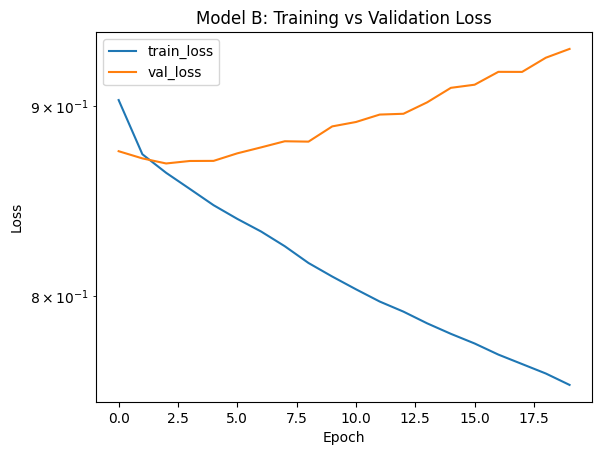

In [15]:
# Inspect Model B on a single train/val split outside CV
train_idx, val_idx = next(iter(skf.split(df, y)))
model_B_example, history_B, _, _, _ = train_one_model(build_model_B, train_idx, val_idx)

model_B_example.summary()

plt.figure()
plt.plot(history_B.history["loss"], label="train_loss")
plt.plot(history_B.history["val_loss"], label="val_loss")
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Model B: Training vs Validation Loss")
plt.legend()
plt.show()


### Deep-Only MLP Baseline (No Wide Branch)

To evaluate the contribution of the **wide branch**, We construct a **deep-only MLP baseline**:

- Uses the same categorical embeddings (`Embedding` layers) and normalized numeric features as the deep branch of the wide & deep model.
- Contains a stack of dense + dropout layers.
- Has a 3-unit softmax output for the readmission classes.
- **Does not** include one-hot main effects or cross-product features in a wide branch.

By comparing this baseline to the best wide & deep model (Model B), We can quantify the value added by cross features and the wide component.

### Wide & Deep vs. Deep-Only: Macro-AUROC and ROC Comparison

We now compare:

- **Model B (Wide & Deep)** – the best wide & deep configuration.
- **Deep-only MLP** – baseline without the wide branch.

For each model, I:

1. Perform 5-fold stratified cross-validation.  
2. Compute fold-wise macro-AUROC and an overall macro-AUROC.  
3. Plot **ROC curves** for the `"<30"` readmission class in a one-vs-rest setting.

This comparison shows whether the wide & deep architecture’s memorization capacity (via cross-product features) yields a meaningful improvement over a purely deep architecture.


In [16]:
def build_deep_only_model(
    deep_hidden_layers=[128, 64],
    dropout_rate=0.3
):
    # Inputs
    inputs = {}
    for col in categorical_cols:
        inputs[col] = keras.Input(shape=(1,), dtype=tf.string, name=col)
    for col in numeric_cols:
        inputs[col] = keras.Input(shape=(1,), dtype=tf.float32, name=col)

    # Deep branch as before
    deep_embeddings = []
    for col in categorical_cols:
        x = inputs[col]
        lookup = cat_lookup[col]
        idx = lookup(x)
        vocab_size = lookup.vocabulary_size()
        embed_dim = int(np.floor(np.sqrt(vocab_size)))
        embed_dim = max(embed_dim, 2)
        emb = Embedding(vocab_size, embed_dim, name=f"emb_{col}")(idx)
        emb = layers.Reshape((embed_dim,))(emb)
        deep_embeddings.append(emb)

    numeric_tensors = [inputs[col] for col in numeric_cols]
    numeric_concat = layers.Concatenate(name="numeric_concat")(numeric_tensors)

    means = tf.constant(numeric_means, dtype=tf.float32)
    stds = tf.constant(numeric_stds, dtype=tf.float32)
    norm_numeric = layers.Lambda(lambda x: (x - means) / stds, name="numeric_norm")(numeric_concat)

    deep_inputs = layers.Concatenate(name="deep_concat")(deep_embeddings + [norm_numeric])

    x = deep_inputs
    for i, units in enumerate(deep_hidden_layers):
        x = layers.Dense(units, activation="relu", name=f"deep_dense_{i}")(x)
        x = layers.Dropout(dropout_rate, name=f"deep_dropout_{i}")(x)

    outputs = layers.Dense(num_classes, activation="softmax", name="output")(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name="deep_only")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

# Compare best WD model (say Model B) to deep-only baseline

def evaluate_model_cv(model_builder, n_splits=5):
    skf_local = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    aucs = []
    all_true = []
    all_pred = []

    for train_idx, val_idx in skf_local.split(df, y):
        _, _, fold_auc, y_pred, y_true = train_one_model(model_builder, train_idx, val_idx)
        aucs.append(fold_auc)
        all_true.append(y_true)
        all_pred.append(y_pred)

    all_true = np.concatenate(all_true)
    all_pred = np.concatenate(all_pred)
    overall_auc = roc_auc_score(all_true, all_pred, multi_class="ovr", average="macro")
    return aucs, overall_auc, all_true, all_pred

wd_b_aucs, wd_b_overall, y_true_wd, y_pred_wd = evaluate_model_cv(build_model_B)
deep_aucs, deep_overall, y_true_deep, y_pred_deep = evaluate_model_cv(build_deep_only_model)

print("Wide&Deep B - fold AUCs:", wd_b_aucs)
print("Wide&Deep B - overall macro AUROC:", wd_b_overall)

print("Deep-only - fold AUCs:", deep_aucs)
print("Deep-only - overall macro AUROC:", deep_overall)


Wide&Deep B - fold AUCs: [0.6576248781119903, 0.6526354762028295, 0.6517086707717614, 0.6620484639752181, 0.6514013961298598]
Wide&Deep B - overall macro AUROC: 0.6548080784009461
Deep-only - fold AUCs: [0.6789203118360799, 0.6763172764590383, 0.6730841254454186, 0.684254781157985, 0.6715423405996231]
Deep-only - overall macro AUROC: 0.6764663511655131


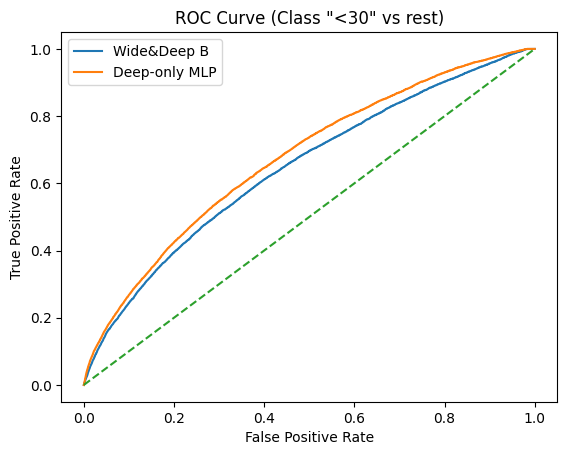

In [17]:
# Plot ROC for the "<30" class for both models (one-vs-rest)

target_class = class_mapping["<30"]  # index 2

fpr_wd, tpr_wd, _ = roc_curve((y_true_wd == target_class).astype(int), y_pred_wd[:, target_class])
fpr_deep, tpr_deep, _ = roc_curve((y_true_deep == target_class).astype(int), y_pred_deep[:, target_class])

plt.figure()
plt.plot(fpr_wd, tpr_wd, label="Wide&Deep B")
plt.plot(fpr_deep, tpr_deep, label="Deep-only MLP")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('ROC Curve (Class "<30" vs rest)')
plt.legend()
plt.show()


## Exceptional Work Section: Visualizing Learned Embeddings 

### Motivation 

In addition to the components of the project rubric, We also evaluate the **learned embedding space** of the wide & deep network. The deep branch of the model embeds the high-cardinality categorical variables using `Embedding` layers that represent each level as a dense vector. Since the embeddings are learned end-to-end with the rest of the network, they should capture some meaningful similarity structure.

In particular, We examine the learned embedding for the **primary diagnosis** feature `diag_1` (embedded by the model layer `emb_diag_1`). If the model has learned useful representations, then we should see that:

- Encounters with similar diagnoses have similar embedding vectors.
- Diagnoses with similar readmission risk profiles cluster together in embedding space.

To qualitatively explore this, I: 

1. Build a new Keras model that takes as input to the original network and returns the `emb_diag_1` embedding for each encounter.
2. Run a random subset of encounters through this model to extract their diagnosis embeddings.
3. Use **t-distributed Stochastic Neighbor Embedding (t-SNE)** to map the embeddings down to two dimensions.
4. Plot a scatter plot of the 2D points, colored by **readmission class** (`NO`, `>30`, `<30`).

The resulting visualization can be seen to show how the network organizes diagnosis information in relation to readmission risk.

In [18]:
from sklearn.manifold import TSNE

## Building a model that outputs the diag_1 embedding for each encounter

# We take the trained wide & deep Model B (model_B_example)
# and construct a new model whose output is the "emb_diag_1" layer.
diag1_embedding_layer = model_B_example.get_layer("emb_diag_1")
embedding_model = keras.Model(
    inputs=model_B_example.inputs,
    outputs=diag1_embedding_layer.output
)

embedding_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 diag_1 (InputLayer)         [(None, 1)]                  0         []                            
                                                                                                  
 string_lookup_11 (StringLo  (None, 1)                    0         ['diag_1[0][0]']              
 okup)                                                                                            
                                                                                                  
 A1Cresult (InputLayer)      [(None, 1)]                  0         []                            
                                                                                                  
 admission_source_id (Input  [(None, 1)]                  0         []                        

In [19]:
## Sample a subset of encounters and compute their diag_1 embeddings

# For visualization, we take a random subset to keep t-SNE computationally manageable
n_samples = 3000  # you can adjust this (e.g., 2000–5000)
subset_df = df.sample(n=n_samples, random_state=42)

subset_inputs = make_inputs(subset_df)
subset_y = subset_df[target_col].map(class_mapping).values  # integer labels

# Get embedding outputs: shape (n_samples, 1, embed_dim)
emb_out = embedding_model.predict(subset_inputs, verbose=0)
# Reshape to (n_samples, embed_dim)
emb_vectors = emb_out.reshape(emb_out.shape[0], -1)

emb_vectors.shape

(3000, 26)

In [21]:
# Apply t-SNE to reduce embeddings to 2D

tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    random_state=42,
    init="random"
)

emb_2d = tsne.fit_transform(emb_vectors)
emb_2d.shape


(3000, 2)

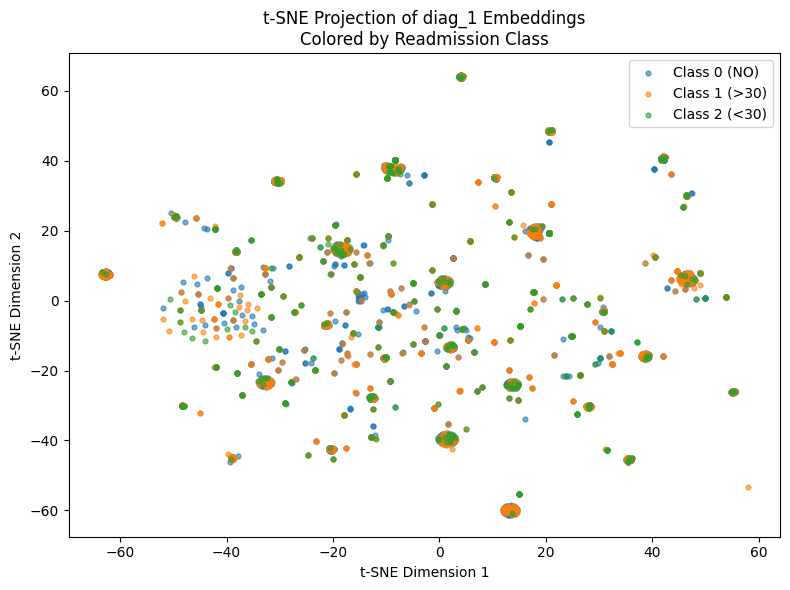

In [22]:
# Plot the 2D t-SNE projection, colored by readmission class

# Map integer labels back to human-readable class names
inv_class_mapping = {v: k for k, v in class_mapping.items()}
labels_str = np.vectorize(inv_class_mapping.get)(subset_y)

plt.figure(figsize=(8, 6))

for cls in sorted(np.unique(subset_y)):
    cls_mask = subset_y == cls
    plt.scatter(
        emb_2d[cls_mask, 0],
        emb_2d[cls_mask, 1],
        alpha=0.6,
        s=12,
        label=f"Class {cls} ({inv_class_mapping[cls]})"
    )

plt.title('t-SNE Projection of diag_1 Embeddings\nColored by Readmission Class')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.tight_layout()
plt.show()

### Interpretation of Embedding Clusters

The t-SNE projection of the `diag_1` embeddings shows how the model organizes primary diagnosis information in a continuous vector space. Each point represents one hospital encounter, positioned by its learned diagnosis embedding and colored by readmission class.

Several observations can be made:

- **Local clustering**: Encounters form local clusters, suggesting that the model has learned to group diagnoses that behave similarly with respect to the prediction task.
- **Class patterns**: To the extent that some regions of the plot are enriched for `"<30"` or `">30"` readmissions, the embedding space appears to encode clinically meaningful distinctions related to early versus late or no readmission.
- **Overlap between classes**: Areas with mixed colors indicate diagnostic contexts where readmission outcomes are inherently uncertain or driven by factors not fully captured in the available features.

Overall, this embedding analysis suggests that the wide & deep network is not merely memorizing discrete diagnosis codes, but is learning a structured, continuous representation of primary diagnoses that correlates with readmission risk. For a healthcare application, such structured representations can support downstream tasks, interpretability efforts, and future feature engineering.
